<a href="https://colab.research.google.com/github/kavyajeetbora/nlp_doc/blob/master/notebooks/01_simple_local_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the environment

Takes about 3 mins to setup

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements in quiet mode.")
    !pip install -U -q torch  # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install -q PyMuPDF # for reading PDFs with Python
    !pip install -q tqdm # for progress bars
    !pip install -U -q sentence-transformers # for embedding models
    !pip install -q accelerate # for quantization model loading
    !pip install -q bitsandbytes # for quantizing models (less storage space)
    !pip install -q flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.2 MB/s eta 0:00:00
  

## Download the PDF

Based on which we will build our QA application

In [2]:
# The URL of the PDF you want to download
!wget "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf" -O "Human Nutrition.pdf"

--2024-04-13 07:48:30--  https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf
Resolving pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)... 128.171.43.156
Connecting to pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)|128.171.43.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26891229 (26M) [application/pdf]
Saving to: ‘Human Nutrition.pdf’

Human Nutrition.pdf 100%[===================>]  25.64M  13.3MB/s    in 1.9s    

2024-04-13 07:48:32 (13.3 MB/s) - ‘Human Nutrition.pdf’ saved [26891229/26891229]



## Read the content of the PDF

We will use PyMuPDF

In [3]:
import fitz
from tqdm.notebook import tqdm
import random

In [4]:
## Some text formatting function before extracting the text

def text_formatter(text:str)->str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text


## Here we can define more text preprocessing functions

About token

Tokens can be thought of as pieces of words. Before the API processes the request, the input is broken down into tokens. These tokens are not cut up exactly where the words start or end - tokens can include trailing spaces and even sub-words

Use this [tokenizer tool](https://platform.openai.com/tokenizer) to try it out

In [5]:
pdf = fitz.open('Human Nutrition.pdf')

def open_and_read_pdf(pdf_path:str) -> list[dict]:
    doc = fitz.open(pdf_path)

    pages_and_text = []

    for page_number, page in tqdm(enumerate(doc)):
        raw_text = page.get_text()
        cleaned_text = text_formatter(text=raw_text)
        pages_and_text.append(
            {
                "page_number": page_number - 41,
                "page_char_count": len(cleaned_text),
                "page_word_count": len(cleaned_text.split(" ")),
                "page_sentence_count": len(cleaned_text.split(". ")),
                "page_token_count": len(cleaned_text)/ 4, ## One token is ~ 4
                "text": cleaned_text
            }
        )

    return pages_and_text


In [6]:
pages_and_text = open_and_read_pdf("Human Nutrition.pdf")

0it [00:00, ?it/s]

In [7]:
random.sample(pages_and_text,k=3)

[{'page_number': 183,
  'page_char_count': 165,
  'page_word_count': 37,
  'page_sentence_count': 2,
  'page_token_count': 41.25,
  'text': 'Sodium  levels in  milligrams is  a required  listing on a  Nutrition  Facts label.  Sodium on the Nutrition Facts Panel  Figure 3.10 Nutrition Label  Sodium  |  183'},
 {'page_number': 383,
  'page_char_count': 434,
  'page_word_count': 90,
  'page_sentence_count': 3,
  'page_token_count': 108.5,
  'text': 'Proteins are  the  “workhorses”  of the body  and  participate  in many  bodily  functions.  Proteins  come in all  sizes and  shapes and  each is  specifically  structured  for its  particular  function.  Protein’s Functions in the  Body  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Structure and Motion  Figure 6.9 Collagen Structure  Protein’s Functions in the Body  |  383'},
 {'page_number': -29,
  'page_char_count': 973,
  'page_word_count': 173,
  'page_sentence_count': 3,
  'page_t

## Data analysis of the text

In [8]:
import pandas as pd

df = pd.DataFrame(pages_and_text)
df.sample(3)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
780,739,442,67,3,110.5,http:/ /pressbooks.oer.hawaii.edu/ humannutrit...
869,828,1774,290,19,443.5,also contains more calories than colostrum. As...
713,672,702,138,6,175.5,Dietary Reference Intakes for Zinc Table 11.4...


In [9]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


<Axes: xlabel='page_token_count', ylabel='Count'>

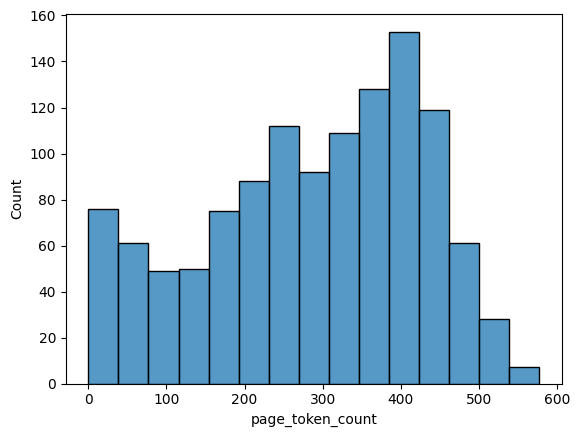

In [10]:
import seaborn as sns

sns.histplot(x='page_token_count', data=df)

Why would we care about token count ?

token count is important to think about:
1. Embedding and LLM models donot deal with infinite tokens


For example the embedding model called [all-mp-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) takes 384 tokens as input. So if we put a input with more than this then the model will cut down the text and information would be lost

As fpr LLMs, they can't accept unlimited tokens

All-mp-base-v2 is not the best embedding model out there but it is small in size so it is easy to get started. Here you can explore the leaderboard to check out the best embedding model: [MTEB Leaderboard on hugging face](https://huggingface.co/spaces/mteb/leaderboard)

## Further text processing (splitting pages into sentences)

For Splitting text into sentences we can use:
1. Manually spitting on ". "
2. Or more robust way is to use spaCy or nltk

We will use spacy [sentencizer](https://spacy.io/api/sentencizer)

In [11]:
from spacy.lang.en import English

nlp = English()

## Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

## Create document instance as an example
doc = nlp("This is a sentence. This is another sentence. And this is the last sentence")
assert len(list(doc.sents)) == 3

## Print out the sentences
list(doc.sents)

[This is a sentence., This is another sentence., And this is the last sentence]

In [12]:
for item in tqdm(pages_and_text):
    item['sentences'] = list(nlp(item['text']).sents)

    item['sentences'] = list(map(str, item['sentences']))

    item['page_sentence_count_spacy'] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_text, k=1)

[{'page_number': -14,
  'page_char_count': 597,
  'page_word_count': 101,
  'page_sentence_count': 5,
  'page_token_count': 149.25,
  'text': 'Alan Titchenal  Dr. Titchenal received a PhD in nutrition from the University  of California at Davis with emphasis on exercise physiology and  physiological chemistry. His work at the University of Hawai‘i at  Mānoa has focused on the broad areas of nutrition and human  performance and translation of nutrition science for public  consumption. This has included the “Got Nutrients?” project that  provides daily messages on topics related to nutrition, fitness, and  health and the publication of over 600 articles in the Honolulu Star- Advertiser newspaper.  \xa0 xxviii  |  About the Contributors',
  'sentences': ['Alan Titchenal  Dr. Titchenal received a PhD in nutrition from the University  of California at Davis with emphasis on exercise physiology and  physiological chemistry.',
   'His work at the University of Hawai‘i at  Mānoa has focused on

In [14]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


## Chunking our sentences together


The concept of splitting the larger pieces of text into smaller ones is referred to as text splitting or chunking

There is no 100% correct way of doing this. Still on research. For demonstration we will keep it simple, we will split the text into group of 10 sentences.

There are frameworks like LangChain which can help with splitting the text into chunks: [Text-Splitters in LangChain](https://python.langchain.com/docs/modules/data_connection/document_transformers/)


1. Model compatibility: You may want to split a long document into smaller chunks that can fit into your **model's context window**

Say we have a sentence like this and we tokenize it:

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/0*fS-xiimLEZDBO6JX.png' height=200/>

This long sentence results in 68 tokens. But may be there will be sentence that will be longer than this and results in tokens more than the model token limit


Also we don't want to use more tokens that may result in higher price and computation:

GPT 4 Token limits and corresponding price:

<img src='https://www.slideteam.net/media/catalog/product/cache/1280x720/c/h/chat_gpt_4_api_pricing_details_how_to_use_openai_api_in_business_chatgpt_ss_slide01.jpg' height=200/>





In [15]:
chunk_size=10

## Create a function to split the list of texts recursively into chunk size
## E.g = [20] -> [10,10] or [25] -> [10,10,5]

def split_list(input_list: list, slice_size:int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

## Test
test_list = list(range(25))
split_list(test_list, chunk_size)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [16]:
for item in tqdm(pages_and_text):
    item['sentence_chunks'] = split_list(item['sentences'], chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [17]:
random.sample(pages_and_text, k=1)

[{'page_number': 995,
  'page_char_count': 1073,
  'page_word_count': 182,
  'page_sentence_count': 7,
  'page_token_count': 268.25,
  'text': 'lead to symptoms that are also common to food infection, such  as abdominal cramping, while others can cause different kinds of  symptoms and complications, some very severe. For example,  mercury, which is sometimes found in fish, can cause neurological  damage in infants and children. Exposure to cadmium can cause  kidney damage, typically in elderly people.  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activitie

## Splitting each chunk into its own item



In [18]:
 import re

 pages_and_chunks = []

 for item in tqdm(pages_and_text):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        ## Join the sentence Chunk
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r"\.([A-Z])", r'. \1', joined_sentence_chunk) ## .A => . A; This will work with any letter

        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk word count'] = len(joined_sentence_chunk.split(" "))
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk)/4 ## 1 token ~ 4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [19]:
random.sample(pages_and_chunks,k=1)

[{'page_number': 692,
  'sentence_chunk': 'Molybdenum UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM Molybdenum also acts as a cofactor that is required for the metabolism of sulfur-containing amino acids, nitrogen-containing compounds found in DNA and RNA, and various other functions. Deficiency of molybdenum is not seen in healthy people, however, a rare metabolic effect called molybdenum cofactor deficiency is the result of an insufficient amount of molybdoenzymes in the body. Due to rapid excretion rates in the urine of the mineral, molybdenum toxicity is low in humans. \xa0 Dietary Reference Intakes of Molybdenum: The recommended intake for molybdenum is 45 mcg per day for both adult males and females. Table 1: Dietary Reference Intakes for Molybdenum Age group RDA (μg/ day) UL (μg/ day) Infants (0-6 months) – Infants (6-12 months) – Children (1-3 years) 17 300 Children (4-8 years) 22 600 Children (9-13 years) 34 1,100 Adolescen

In [20]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk word count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


<Axes: xlabel='chunk_token_count', ylabel='Count'>

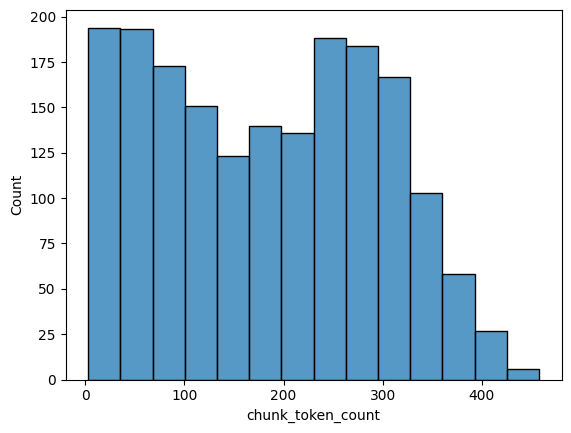

In [21]:
sns.histplot(x='chunk_token_count', data=df)

The embedding model that we are going to use has 384 token limit and from the distribution above we can see most of our chunks are having token size less than that

Also there might be sentences that are having very very less tokens which may not carry useful information for our purpose. Let's say chunks with less than 30 tokens can be considered insignificant and be removed

In [22]:
df[df['chunk_token_count']<30].sample(5)

,page_number,sentence_chunk,chunk_char_count,chunk word count,chunk_token_count
706,442,442 | Health Consequences of Alcohol Abuse,42,7,10.50
1343,862,http:/ /www.aafp.org/afp/ 2002/1001/p1217.html...,67,7,16.75
342,205,Consequences of Deficiency or Excess | 205,42,7,10.50
154,77,It is stored in the rectum until it is expelle...,106,20,26.50
283,169,"In exchange, for the reabsorption of sodium an...",111,18,27.75


In [23]:
pages_and_chunks = df[df['chunk_token_count']>30].to_dict(orient='records')
len(pages_and_chunks)

1680

In [24]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 1152,
  'sentence_chunk': 'Nutrient RDA/ AIb (men / women) ages 31-50 Daily Value (Food Labels) ULc SUL or Guidance Leveld Selected Potential Effects of Excess Intake Vitamin A (mcg) 900 / 700 1500 (5000 IU) 3000 1500** (5000 IU) Liver damage, bone & joint pain, dry skin, loss of hair, headache, vomiting beta-Carotene (mg) – – – 7 (11,655 IU) Increased risk of lung cancer in smokers and those heavily exposed to asbestos Vitamin D (mcg) 15 (600 IU) 10 (400 IU) 100 25 (1000 IU) Calcification of brain, arteries, increased blood calcium, loss of appetite, nausea Vitamin E (mg) 15 20 (30 IU) 1000 540 (800 IU) Deficient blood clotting Vitamin K (mcg) 120 / 90* 80 – 1000** Red blood cell damage/anemia; liver damage Thiamin (B1) (mg) 1.2 / 1.1 1.5 – 100** Headache, nausea, irritability, insomnia, rapid pulse, weakness (7000+ mg dose) Riboflavin (B2) (mg) 1.3 / 1.1 1.7 – 40** Generally considered harmless; yellow discoloration of urine Niacin (mg) 16 / 14 20 35 500** Liver dama

## Embedding our text chunks

what is embedding ?


In [26]:
import torch
from sentence_transformers import SentenceTransformer

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Here we are using a basic embedding model which quite fast in processing and small is size. You can instead replace this model with a more robust one but only if GPU is available on colab otherwise it will be very slow

In [29]:
embedding_model = SentenceTransformer(model_name_or_path= 'all-MiniLM-L6-v2', device=device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentences are encoded/embedded to a numerical representation using `model.encode()`

In [30]:
sentences = ['Embeddings are representations of values or objects like text, images, and audio that are designed to be consumed by machine learning models and semantic search algorithms.',
'They translate objects like these into a mathematical form according to the factors or traits each one may or may not have, and the categories they belong to']

embeddings = embedding_model.encode(sentences)

for sentence, embedding in zip(sentences, embeddings):
    print(f"Sentence: {sentence}")
    print(f"Shape of the embedding:{(embedding.shape)}")
    break

Sentence: Embeddings are representations of values or objects like text, images, and audio that are designed to be consumed by machine learning models and semantic search algorithms.
Shape of the embedding:(384,)


More the embedding size better the results are in capturing the sentence meaning in a vector form. But also it consumes more space and takes more time in computation.

After embedding the sentences, we can perform a vector search for retrievel of relevant text from the document.


## Embedding all the text chunks of the document

In [31]:
%%time

for item in tqdm(pages_and_chunks):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 2min 41s, sys: 708 ms, total: 2min 41s
Wall time: 2min 54s


Embedding the chunks using batch mode

In [32]:
## extract all text chunks into a list

text_chunks = [item['sentence_chunk'] for item in pages_and_chunks]
len(text_chunks)

1680

In [33]:
%%time
text_chunk_embeddings = embedding_model.encode(
    text_chunks,
    batch_size=32,
    convert_to_tensor=True
)
text_chunk_embeddings

tensor([[-1.9507e-02, -1.8256e-02,  7.1658e-04,  ..., -3.9904e-02,
         -2.1543e-02, -4.3294e-02],
        [ 2.6605e-02,  1.8785e-03, -7.0033e-03,  ..., -2.1591e-02,
         -2.1828e-02, -6.9987e-02],
        [ 3.4971e-02,  4.0597e-02, -1.9747e-02,  ..., -3.5225e-02,
         -3.1397e-02, -4.6613e-02],
        ...,
        [-3.2258e-02, -2.4768e-02, -1.1571e-02,  ..., -1.3912e-05,
          3.9905e-02, -5.2110e-02],
        [-8.8627e-02, -6.6496e-02, -1.0430e-01,  ..., -3.0128e-02,
          8.4004e-02, -4.2208e-02],
        [-1.1203e-01, -4.9535e-02, -2.4897e-02,  ...,  1.2983e-02,
          4.6920e-02, -2.8276e-02]])

Embedding in batch mode is generally faster and preferred way.


## Saving embeddings to a file

In [34]:
df_embed = pd.DataFrame(pages_and_chunks)
df_embed.sample(5)

,page_number,sentence_chunk,chunk_char_count,chunk word count,chunk_token_count,embedding
136,69,"3 molecules of Glucose, Lipids becomes 1 molec...",426,67,106.50,"[0.04758981, -0.08300514, -0.08053162, -0.0315..."
1582,1105,Cancer More than one hundred diseases are clas...,1321,189,330.25,"[0.009790488, -0.027839024, 0.024869781, -0.01..."
186,110,The Urinary System UNIVERSITY OF HAWAI‘I AT MĀ...,1321,201,330.25,"[-0.0100539, -0.00052782096, -0.011991788, 0.0..."
1011,718,Vitamins A and C are now voluntary. • Improved...,169,31,42.25,"[-0.042304743, 0.04067663, -0.01255845, 0.0682..."
1037,737,Table 12.4 Determining Food Portions Food Prod...,1025,169,256.25,"[0.08099308, -0.01238391, 0.030354546, 0.05801..."


In [35]:
df_embed.to_csv('doc_embeddings.csv', index=False)

We can store these embeddings in our database instead of storing it as csv.

if the embeddings are less than 10K then it can be stored as `np.array` or `torch.tensor`

If your embedding database is really large, (eg. 1000K-1M Samples) you might want to use vector database.

[What is a vector database](https://www.pinecone.io/learn/vector-database/)